In [1]:
import NBHD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_metric_learning import distances, losses, miners, reducers

torch.set_printoptions(profile="full")

def get_Cosine_margin(model, x_test, y_test=None):
    def cosine_distance(a, b):
        return 1 - torch.cosine_similarity(a[:, np.newaxis, :], b, dim=-1)
    
    # Compute test samples' Hamming distance
    class_hvs = model.class_hvs.data
    test_enc_hvs = model.encoding(x_test)
    test_Cosine_dist = cosine_distance(test_enc_hvs, class_hvs)

    sorted_test_Cosine_distance, _ = torch.sort(test_Cosine_dist, dim=-1, descending=False)
    test_enc_hvs_Cosine_margin = (sorted_test_Cosine_distance[:,1:]-sorted_test_Cosine_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
    mean_test_Cosine_margin = torch.mean(test_enc_hvs_Cosine_margin).item()

    return mean_test_Cosine_margin

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# # Compute mean Hamming distance between class HVS
	class_hvs = model.quantize_class_hvs(model.class_hvs.data, soft = False)
	# class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	# mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = model.encoding(x_test, soft = False)
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	return mean_test_Hamming_margin

def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc

def visualize(model, test_loader, nClasses, device="cuda"):
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        out = model(data, embedding=False)
        for label in range(nClasses):
            res = out[labels == label].cpu().detach()
            sns.heatmap(res)
            plt.title("label: {}".format(label))
            plt.show()
        break


def test_quantizer(dataset, D = 1000, levels = 3, m=10, HD_lr = 0.05, quant_lr=1.0,  metric_lr = 0.01, enc_type='RP', similarity_type = "cosine"):
    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")
    model = NBHD.HDC(dim = nFeatures, D=D, num_classes=nClasses, m=m, levels=levels, enc_type=enc_type, similarity_type= similarity_type)
    model.init_class(x_train, y_train)

    def plot_quant(label):
        x = torch.linspace( model.quantize_data.weights[0].item() - 5, model.quantize_data.weights[len(model.quantize_data.weights) - 1].item() + 5 , 1000)
        y1 = model.quantize_data(x, soft = False)
        y2 = model.quantize_data(x, soft = True).detach()
        
        plt.plot(x, y1, c="red", label = "Hard Quantization")
        plt.plot(x, y2, c="blue", label = "Soft Quantization")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Quantize function over learning operations. Levels: {}, Iteration:{}".format(levels, label))
        plt.legend()
        plt.show()

        sns.displot(model.class_hv_distribution.cpu().flatten().detach())
        for weight in model.quantize_class_hvs.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.title("non-quantized class_hvs distribution")
        plt.show()
        sns.displot(model.class_hvs.cpu().flatten().detach())
        plt.title("quantized class_hvs distribution")
        plt.show()
        
        

        y3 = model.encoding(x_test, quantize=False).cpu().flatten().detach()
        y4 = model.quantize_data(y3, soft = False).cpu()
        sns.displot(y3)
        plt.title("encoding distribution")
        for weight in model.quantize_data.weights.detach():
            plt.axvline(weight, ls="--", c = "red")
        plt.show()
        sns.displot(y4)
        plt.title("encoding quantization distribution")
        plt.show()
        for name, param in model.named_parameters():
            if("quant" in name):
                print(name, param.data)
    
    # plot_quant(0)
    # visualize(model, test_loader, nClasses)

    accuracies = []
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins = []
    margins.append(get_Cosine_margin(model, x_test, y_test))
    device = "cuda"
    
    # before = model.class_hvs.clone().detach()

    num_quant_epochs = 50
    quant_lr = quant_lr

    optimizer = optim.SGD(model.parameters() , quant_lr)

    def cosineLoss(embeddings, labels, t=0.7):
        similarities = model.similarity(model.class_hvs, embeddings)
        a = (1 - similarities[torch.arange(similarities.size(0)), labels]).abs().mean()
        similarities[torch.arange(similarities.size(0)), labels] = 0
        b = similarities.abs().mean()
        return t * a + (1-t) * b

    quant_loss = cosineLoss
    for epoch_i in range(1, num_quant_epochs + 1):
        NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    num_HD_epoch = 10

    for epoch_i in range(1, num_HD_epoch+1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))

    num_metric_epochs = 0
    metric_lr = metric_lr
    model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
    optimizer = optim.Adam(model.parameters(), lr=metric_lr)
    distance = distances.CosineSimilarity()

    reducer = reducers.ThresholdReducer(low=0.0)
    loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    mining_func = miners.TripletMarginMiner(
        margin=0.2, distance=distance, type_of_triplets="semihard", )

    ### pytorch-metric-learning stuff ###
    for epoch_i in range(1, num_metric_epochs + 1):
        NBHD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))
        # for name, param in model.named_parameters():
        #     if("quant" in name):
        #         print(name, param.data)


    # if(num_metric_epochs > 0):
    #     plot_quant(num_metric_epochs)

    
    plt.plot(accuracies, label="Accuracy", c = "blue")
    plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.axvline(x=10, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions, Dataset:{}".format(levels, D, dataset))
    plt.legend()
    plt.show()
    print("Maximum Accuracy:{}".format(max(accuracies)))
    
    # print("class hv equality: ", torch.equal(before, model.class_hvs) )

    # plot_quant("End")
    # visualize(model, test_loader, nClasses)
    #print('Level:',level," Metric_lr:",metric_lr, " Accuracies:" ,accuracies, "Margins:", margins)
    return accuracies

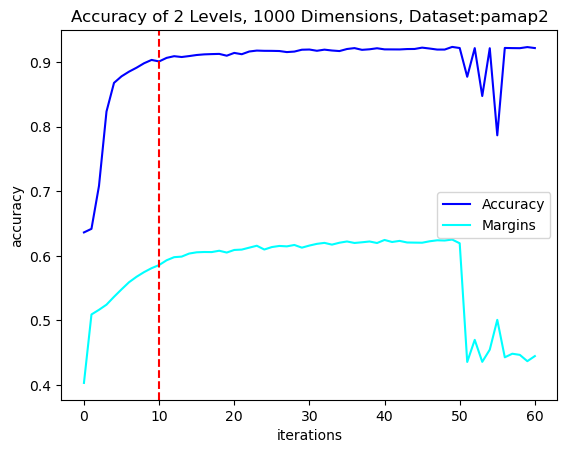

Maximum Accuracy:0.92352294921875


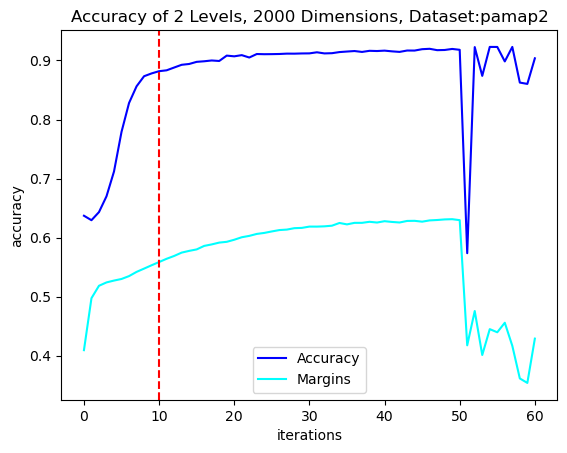

Maximum Accuracy:0.92291259765625


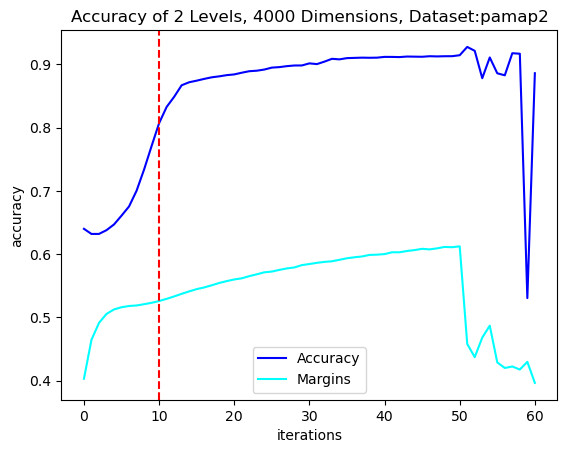

Maximum Accuracy:0.92755126953125


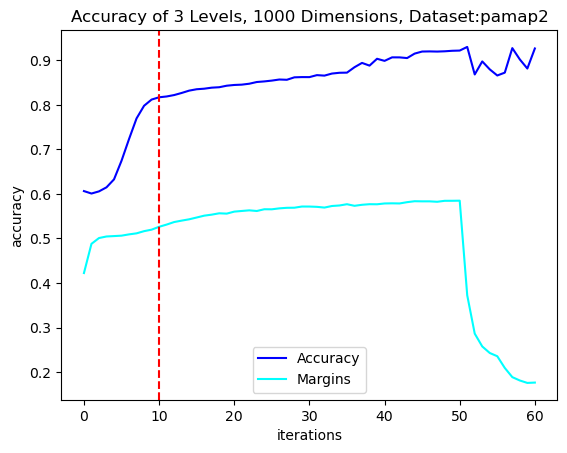

Maximum Accuracy:0.93017578125


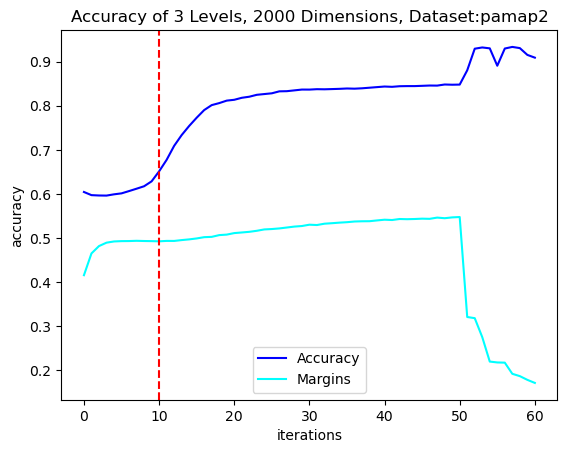

Maximum Accuracy:0.9334716796875


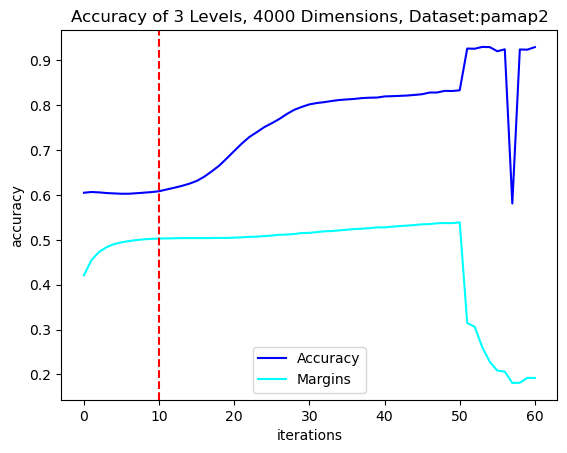

Maximum Accuracy:0.9300537109375


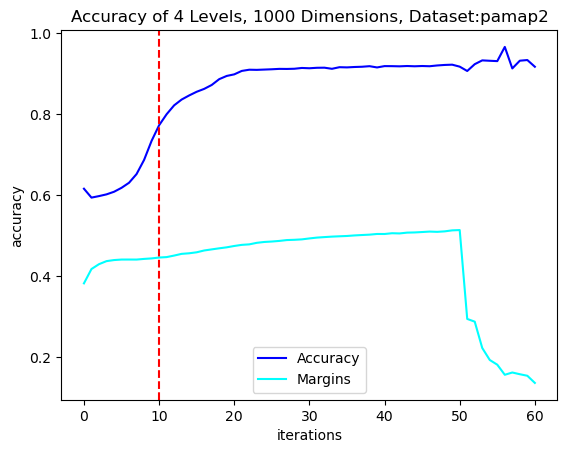

Maximum Accuracy:0.96636962890625


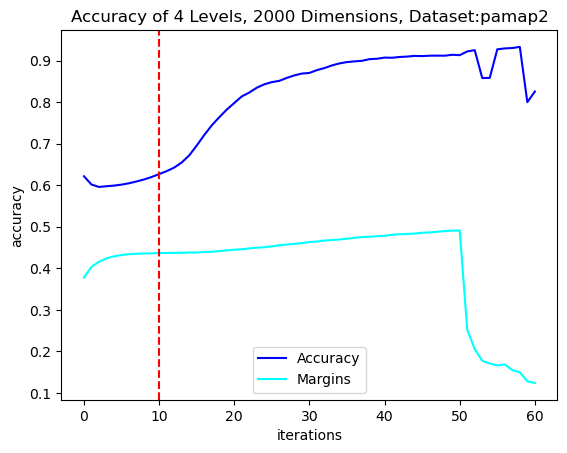

Maximum Accuracy:0.93310546875


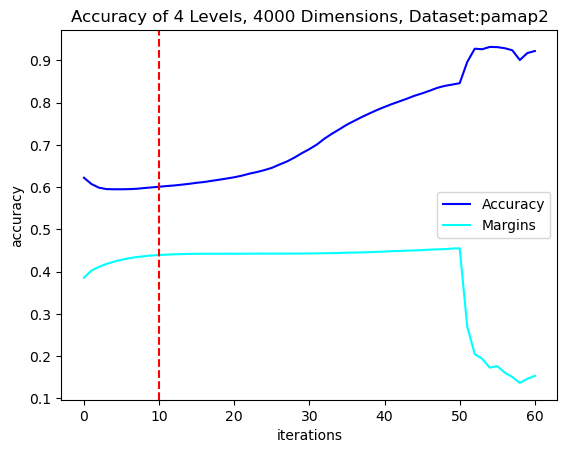

Maximum Accuracy:0.9315185546875


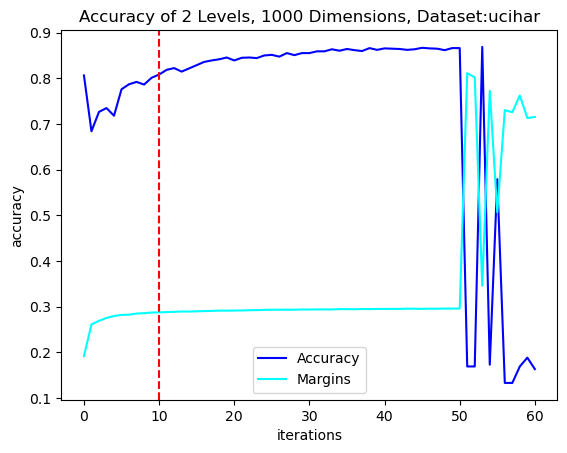

Maximum Accuracy:0.8687258958816528


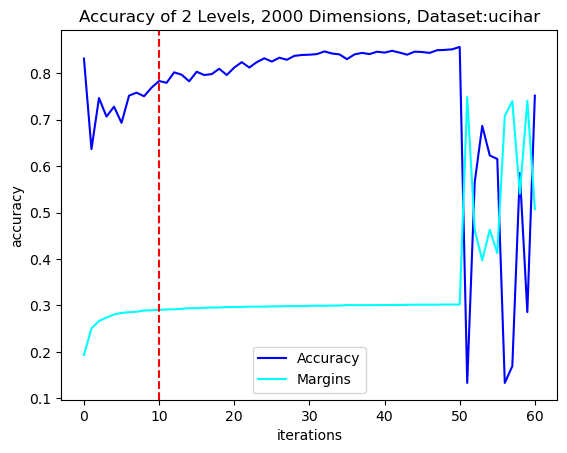

Maximum Accuracy:0.8564993739128113


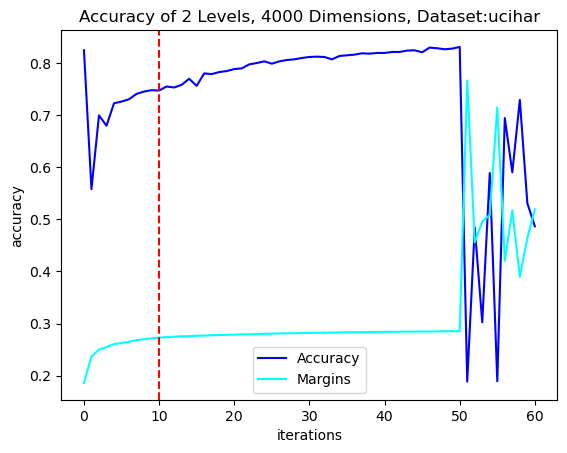

Maximum Accuracy:0.8307593464851379


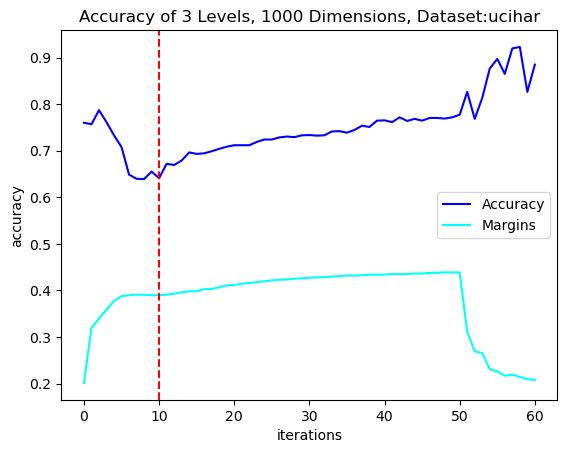

Maximum Accuracy:0.92277991771698


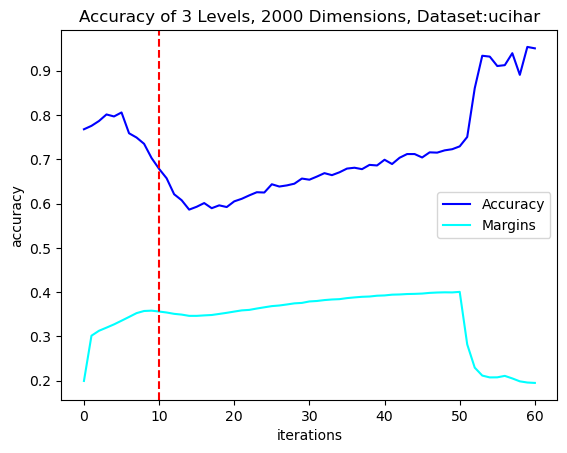

Maximum Accuracy:0.953667938709259


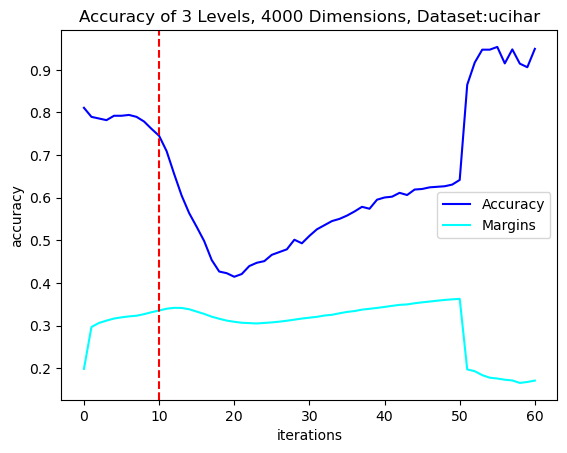

Maximum Accuracy:0.953667938709259


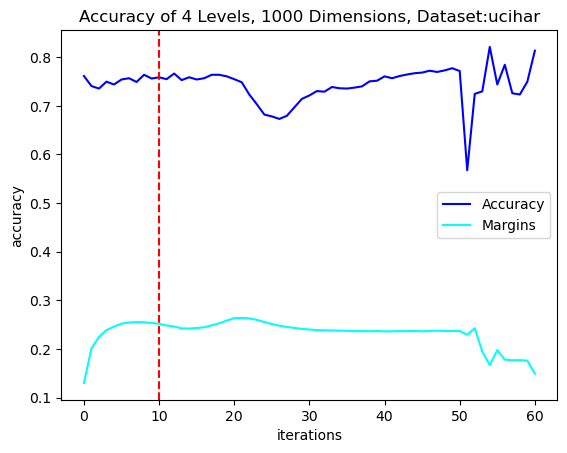

Maximum Accuracy:0.8211068511009216


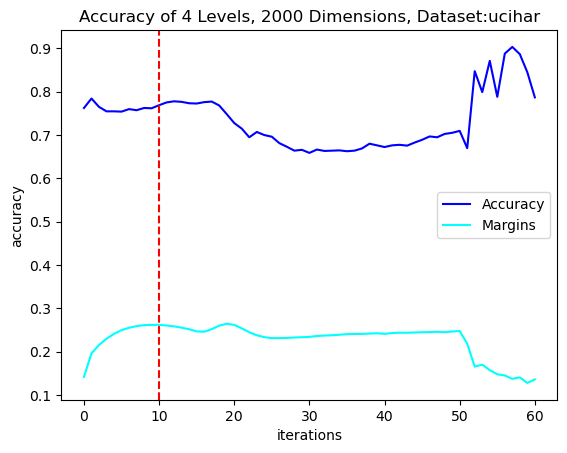

Maximum Accuracy:0.9034749269485474


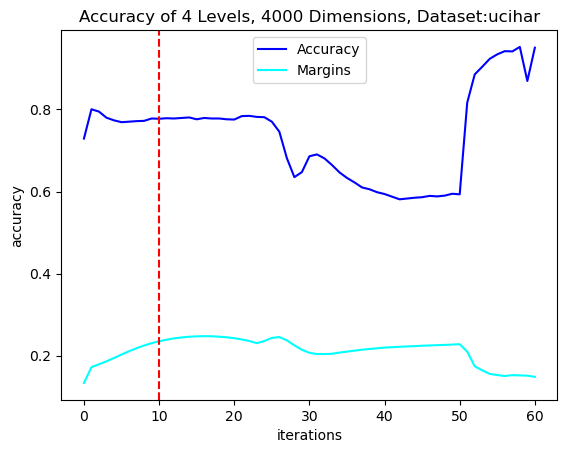

Maximum Accuracy:0.9523809552192688


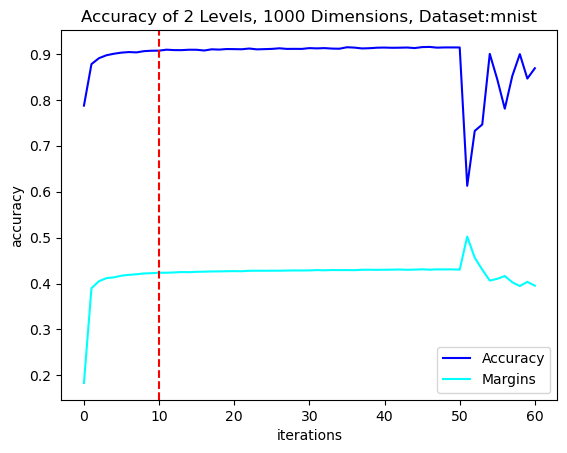

Maximum Accuracy:0.9151999950408936


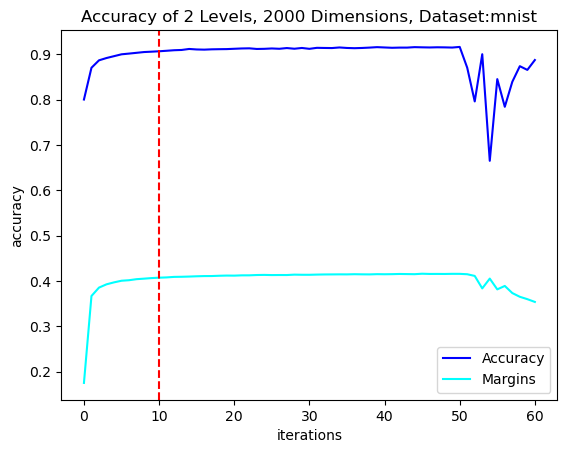

Maximum Accuracy:0.9162999987602234


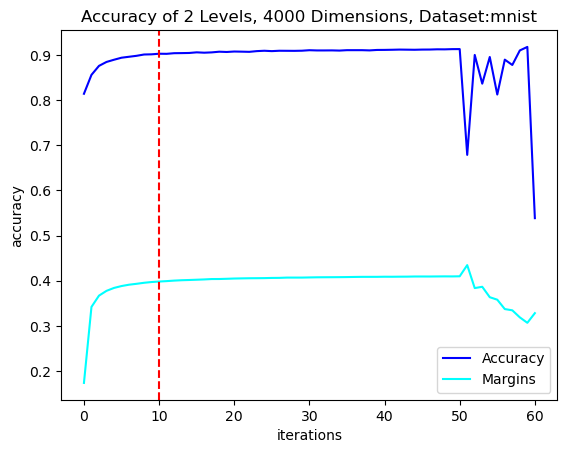

Maximum Accuracy:0.9179999828338623


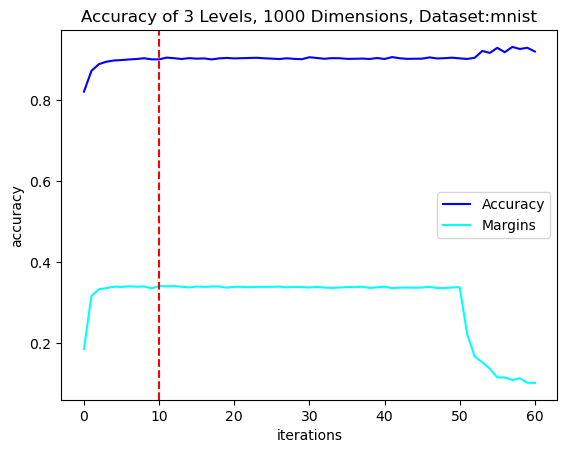

Maximum Accuracy:0.9314000010490417


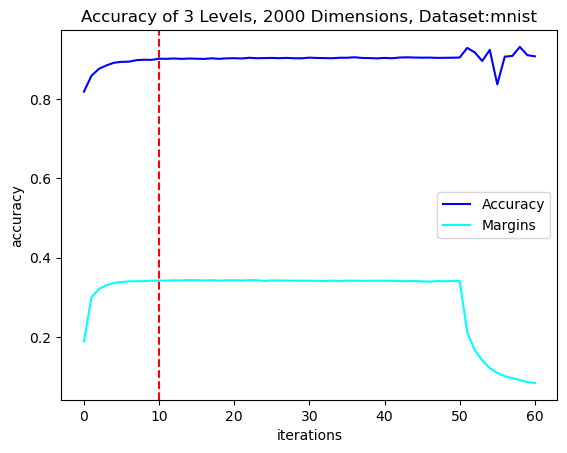

Maximum Accuracy:0.9309999942779541


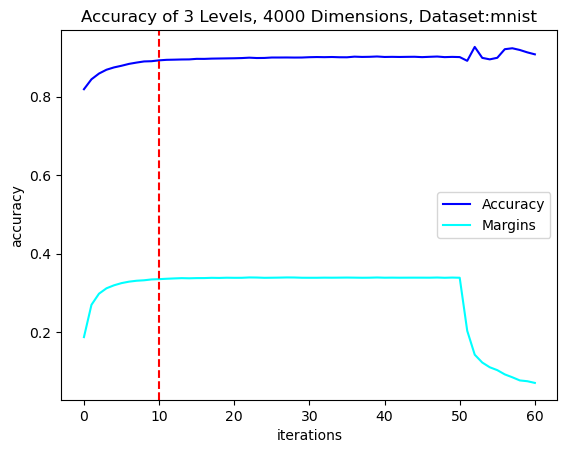

Maximum Accuracy:0.9265999794006348


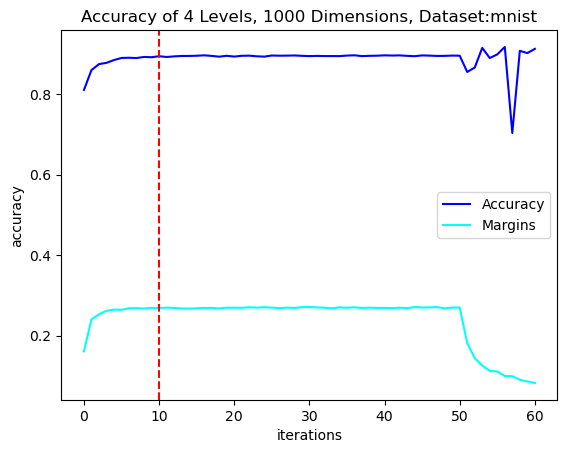

Maximum Accuracy:0.917199969291687


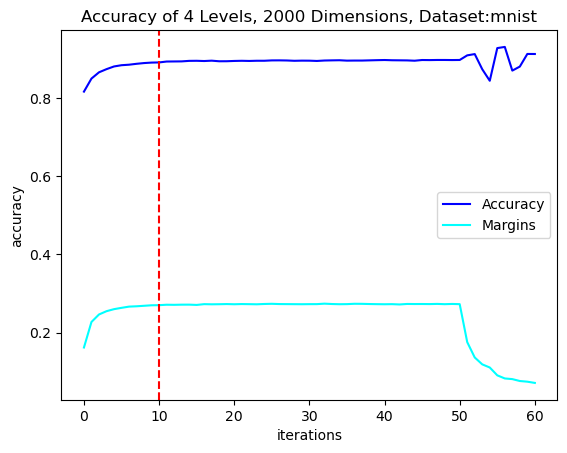

Maximum Accuracy:0.930899977684021


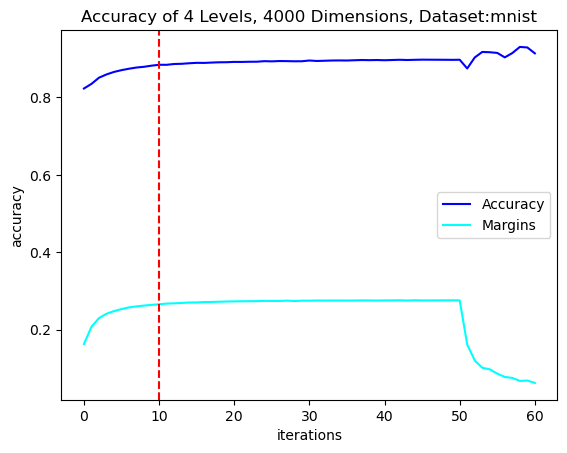

Maximum Accuracy:0.9305999875068665


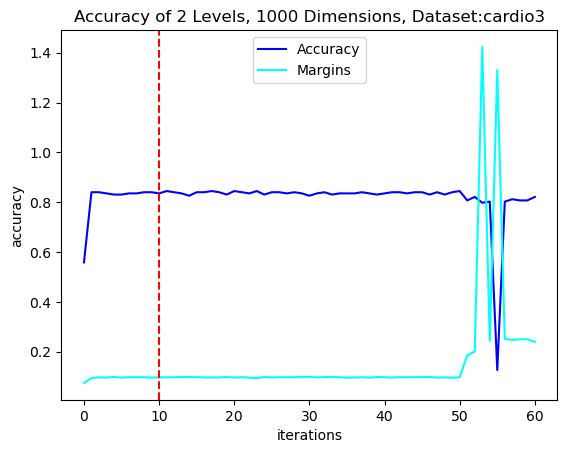

Maximum Accuracy:0.8450704216957092


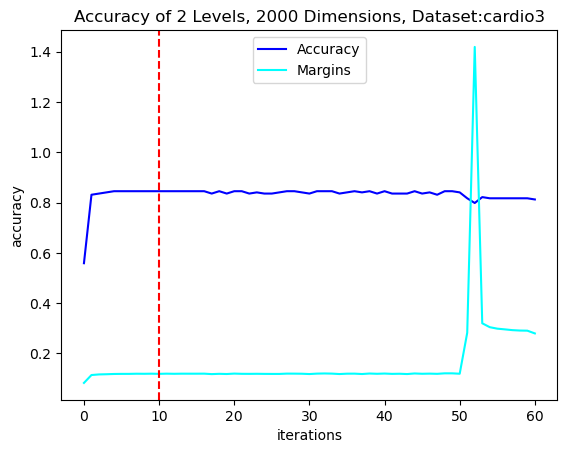

Maximum Accuracy:0.8450704216957092


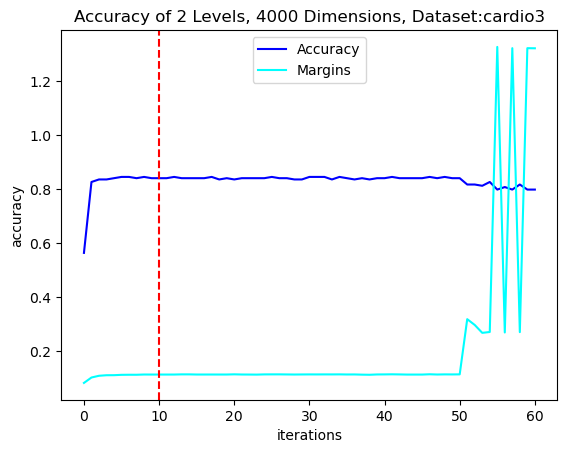

Maximum Accuracy:0.8450704216957092


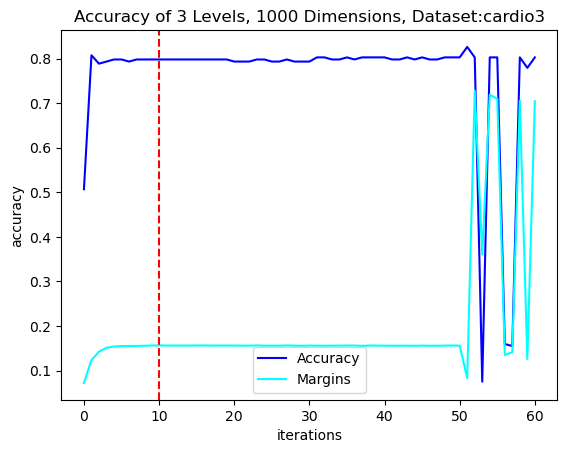

Maximum Accuracy:0.8262910842895508


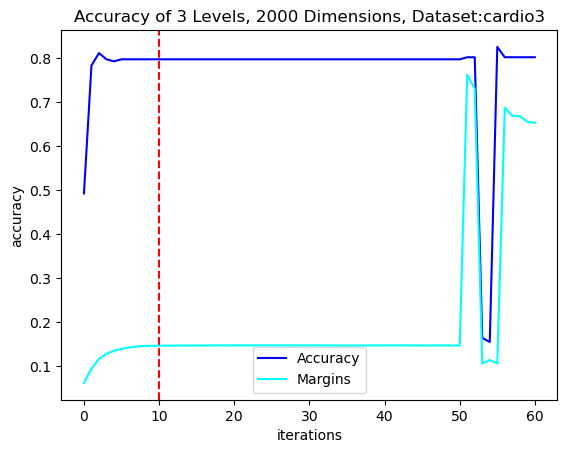

Maximum Accuracy:0.8262910842895508


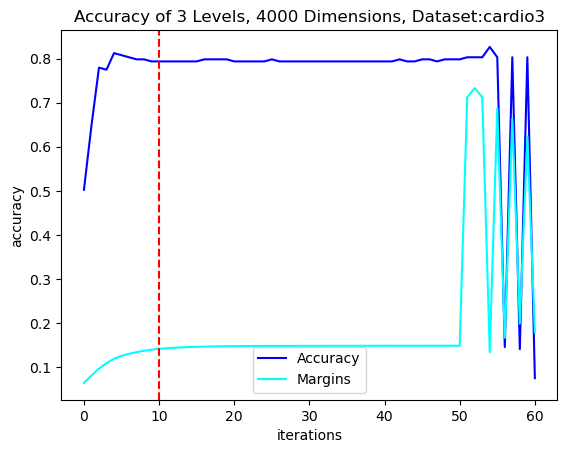

Maximum Accuracy:0.8262910842895508


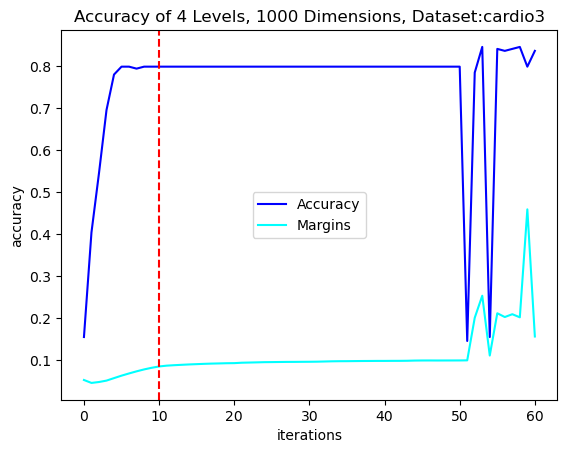

Maximum Accuracy:0.8450704216957092


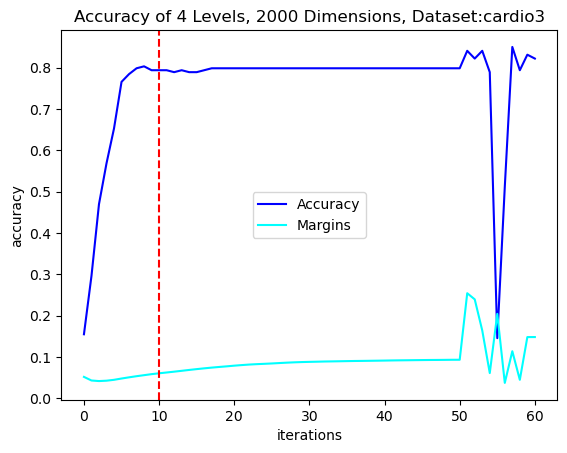

Maximum Accuracy:0.8497652411460876


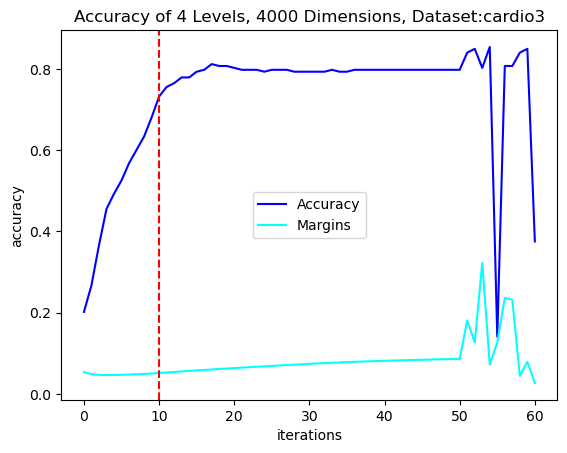

Maximum Accuracy:0.8544601202011108


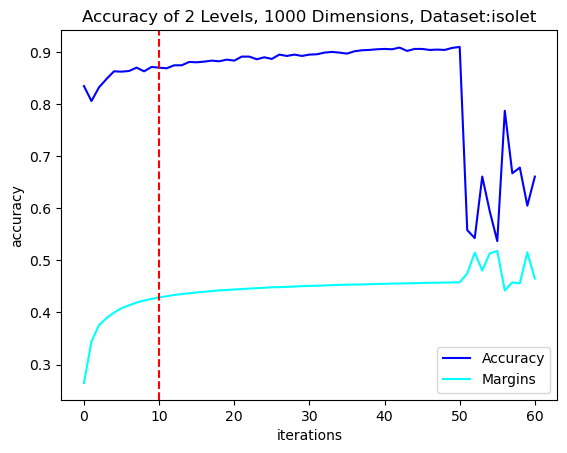

Maximum Accuracy:0.9095574617385864


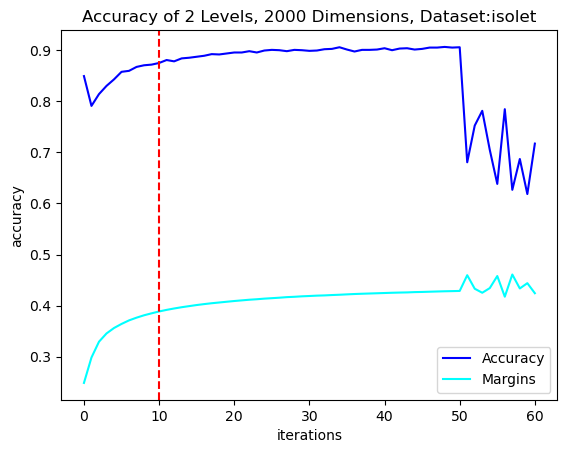

Maximum Accuracy:0.9063502550125122


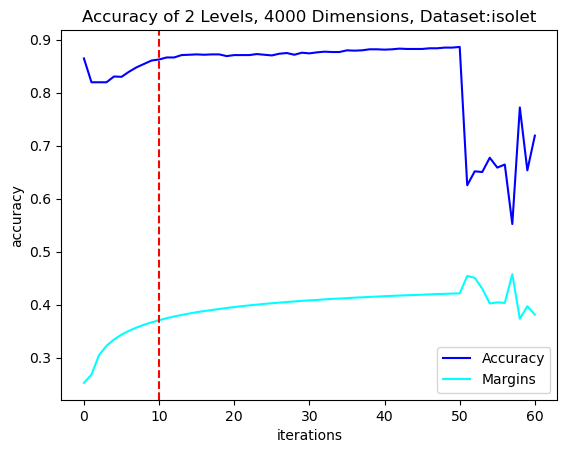

Maximum Accuracy:0.8864657282829285


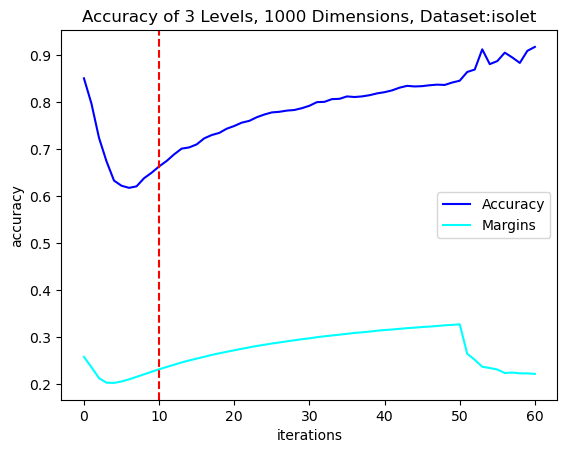

Maximum Accuracy:0.9172546863555908


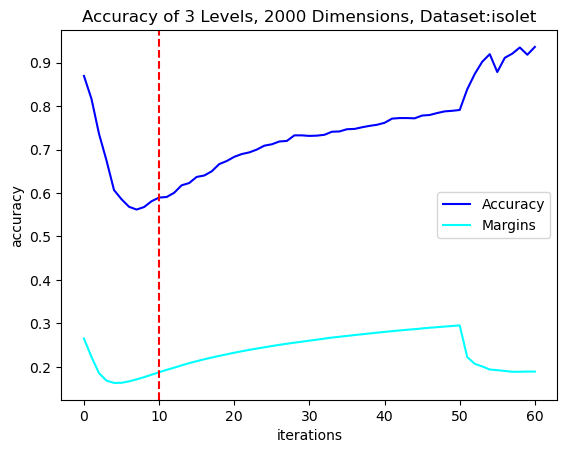

Maximum Accuracy:0.9358563423156738


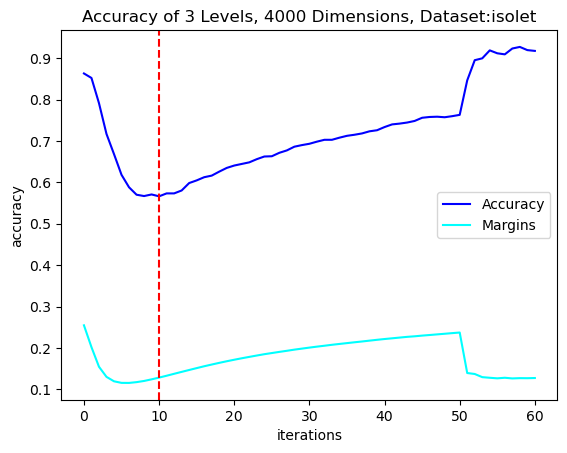

Maximum Accuracy:0.9275176525115967


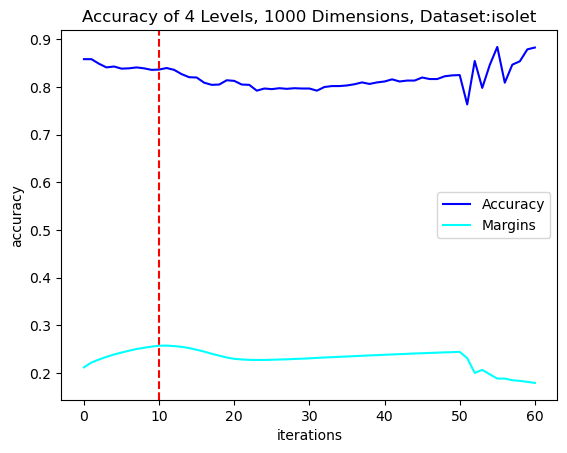

Maximum Accuracy:0.883899986743927


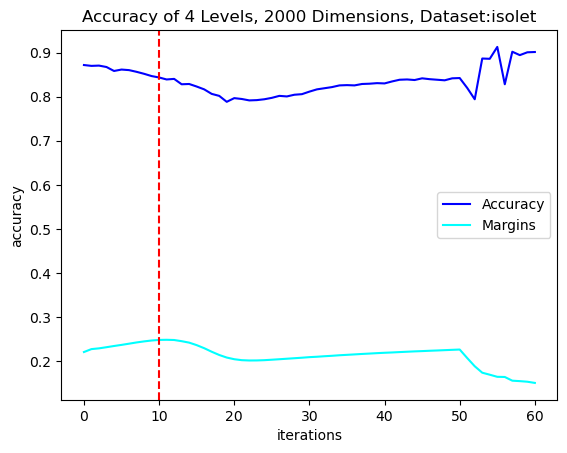

Maximum Accuracy:0.9127646088600159


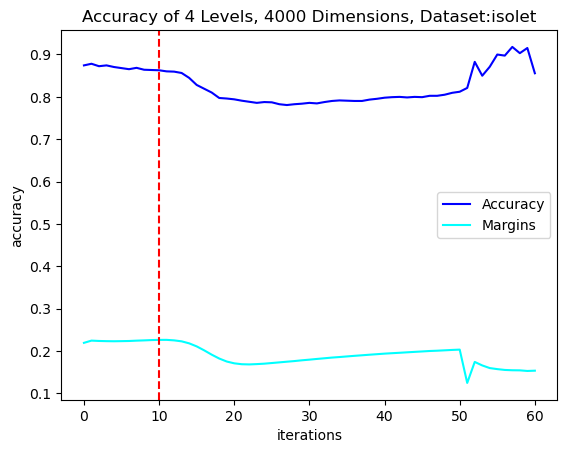

Maximum Accuracy:0.9178960919380188


In [2]:
datasets = ["pamap2","ucihar", "mnist", "cardio3", "isolet"]
# datasets = ["mnist"]
levels = [2,3,4]
metric_lrs = [0.0001]
HD_lrs =[1]
accs = {}
dimensions = [1000,2000,4000]
quant_lrs = [1.0]
for dataset in datasets:
    for level in levels:
        for HD_lr in HD_lrs:
            for metric_lr in metric_lrs:
                for quant_lr in quant_lrs:
                    for dimension in dimensions:

                        acc = test_quantizer(dataset=dataset,levels = level, D = dimension, quant_lr =quant_lr, 
                        metric_lr = metric_lr ,HD_lr=HD_lr, enc_type="RP", similarity_type = "cosine")

                        accs[(dataset, level, dimension)] = acc

In [3]:
max_accs = {}
for key, val in accs.items():
    max_accs[key] = max(val)
print(max_accs)

import csv

with open('50q_10HD.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in max_accs.items():
        writer.writerow([key, value])

{('pamap2', 2, 1000): 0.92352294921875, ('pamap2', 2, 2000): 0.92291259765625, ('pamap2', 2, 4000): 0.92755126953125, ('pamap2', 3, 1000): 0.93017578125, ('pamap2', 3, 2000): 0.9334716796875, ('pamap2', 3, 4000): 0.9300537109375, ('pamap2', 4, 1000): 0.96636962890625, ('pamap2', 4, 2000): 0.93310546875, ('pamap2', 4, 4000): 0.9315185546875, ('ucihar', 2, 1000): 0.8687258958816528, ('ucihar', 2, 2000): 0.8564993739128113, ('ucihar', 2, 4000): 0.8307593464851379, ('ucihar', 3, 1000): 0.92277991771698, ('ucihar', 3, 2000): 0.953667938709259, ('ucihar', 3, 4000): 0.953667938709259, ('ucihar', 4, 1000): 0.8211068511009216, ('ucihar', 4, 2000): 0.9034749269485474, ('ucihar', 4, 4000): 0.9523809552192688, ('mnist', 2, 1000): 0.9151999950408936, ('mnist', 2, 2000): 0.9162999987602234, ('mnist', 2, 4000): 0.9179999828338623, ('mnist', 3, 1000): 0.9314000010490417, ('mnist', 3, 2000): 0.9309999942779541, ('mnist', 3, 4000): 0.9265999794006348, ('mnist', 4, 1000): 0.917199969291687, ('mnist', 4, 